# COGS 108 - Capstone Project
## Group Members:
- Vincent Tierra   - A12654756
- Adrian Herrmann  - A14202007
- Lynley Yamaguchi - A12209358



In [70]:
# Imports -  These are all you need for the assignment: do not import additional packages
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import patsy
import statsmodels.api as sm
from scipy.stats import ttest_ind

## Part 1: Load & Clean the Data

In [71]:
# Import the data from the files into Dataframes

df_edd = pd.read_csv('FluEDD.csv')
df_h = pd.read_csv('FluHospitalization.csv')
df_poverty = pd.read_csv('SDPoverty.csv')
df_median_income = pd.read_csv('SDMedianIncome.csv')

In [72]:
# Replace NaN values with 0 

df_edd.fillna(value=0, inplace=True)
df_h.fillna(value=0, inplace=True)
df_poverty.fillna(value=0,inplace=True)

In [73]:
# Drop unnecessary columns in hospital and discharge dataframe
df_h.drop(['CONDITION', 'OUTCOME'], axis=1, inplace=True)
df_edd.drop(['CONDITION', 'OUTCOME'], axis=1, inplace=True)

In [74]:
# Drop unnecessary columns in poverty dataframe
df_p = df_poverty.drop(['Families below poverty level','Families with children under 18 years below poverty level'], axis=1)

# Drop unnecessary columns in median income dataframe
df_median_income.drop(['median_household_income', 'persons_per_household'], axis = 1, inplace = True)
df_median_income = df_median_income[df_median_income['Geography'] != 'San Diego County']

In [75]:
# Create Dataframe with needed columns
df_h = df_h[['YEAR', 'Geography', 'RegionName', 'Total_Rate']]
df_edd = df_edd[['YEAR', 'Geography', 'RegionName', 'Total_Rate']]

# Group the Geographies to get the average rate over all 4 years (for mean)
df_h_mean = df_h.drop('YEAR', axis=1)
df_edd_mean = df_edd.drop('YEAR', axis=1)
df_h_mean = df_h_mean.groupby(['Geography', 'RegionName'], as_index=False).mean()
df_edd_mean = df_edd_mean.groupby(['Geography', 'RegionName'], as_index=False).mean()

# Drop regions which are only the total of other regions (repetitive)
df_h_mean.drop([3, 9, 25, 26, 27, 36, 41], axis = 0, inplace=True)
df_h_mean = df_h_mean.reset_index(drop=True)
df_edd_mean.drop([3, 9, 25, 26, 27, 36, 41], axis=0, inplace=True)
df_edd_mean = df_edd_mean.reset_index(drop=True)
df_p_mean = df_p.drop([0, 4, 16, 24, 30, 41], axis = 0)
df_p_mean = df_p_mean.reset_index(drop = True)

In [76]:
# Rename the total rate for h and edd
df_h = df_h.rename(columns={ 'Total_Rate' : 'total_rate_h'})
df_edd = df_edd.rename(columns={ 'Total_Rate' : 'total_rate_edd'})
df_h_mean = df_h_mean.rename(columns={ 'Total_Rate' : 'total_rate_h'})
df_edd_mean = df_edd_mean.rename(columns={ 'Total_Rate' : 'total_rate_edd'})

In [77]:
# Merge flu case, poverty, and median income data into one Dataframe
df = df_median_income.merge(df_h_mean.merge(df_edd_mean, how='left', on=['Geography', 'RegionName']), how='right', on='Geography')
df = df_p_mean.merge(df, how='right', on='Geography')
df.rename(columns={'Geography': 'geography', 'RegionName' : 'region_name',  'Population below 100% federal poverty level (FPL)' \
                   : 'poverty_pop'}, inplace=True)

# For separate years
# Merge hospital data and poverty data into one Dataframe
df_hp = pd.merge(df_h,df_p,on='Geography')

# Manually enter some missing data
df.set_value(40, 'pph_income', 27040 + 19341)
df.set_value(39, 'pph_income', 33196)
df.set_value(40, 'poverty_pop', 10.3 + 21.8)
df.set_value(39, 'poverty_pop', 6.7)
df.set_value(38, 'poverty_pop', 24.5)
df.set_value(37, 'poverty_pop', 5.1)
df.set_value(36, 'poverty_pop', 11.5)
df.dropna(inplace=True)

In [78]:
# Clean the dataset incase of missing values to avoid skewing
df = df[(df['total_rate_h'] != 0) | (df['total_rate_edd'] != 0)]
df = df.reset_index(drop=True)

# Display the combined dataset for the mean rate over years
df

,geography,poverty_pop,pph_income,region_name,total_rate_h,total_rate_edd
0,Central San Diego,20.9,30516.0,CENTRAL,11.378619,69.931862
1,Mid-City,26.1,17541.0,CENTRAL,12.626990,84.877651
2,Southeastern San Diego,21.6,14444.0,CENTRAL,12.424052,111.980785
3,Alpine,8.7,31613.0,EAST,0.000000,37.622708
4,El Cajon,21.8,19341.0,EAST,13.295462,62.213675
5,Jamul,7.8,35779.0,EAST,0.000000,86.859562
6,La Mesa,12.0,24951.0,EAST,19.122542,70.301535
7,Lakeside,11.1,25063.0,EAST,3.058264,43.094199
8,Lemon Grove,15.2,19266.0,EAST,11.622501,90.653971
9,Mountain Empire,21.2,19672.0,EAST,0.000000,17.466232


# Part 2: Exploratory Data Visualization

In [ ]:
fig = plt.figure()
ax = Axes3D(fig)
lx = len(df_hp['Geography']['YEAR'==2010])
ly = len(df_hp['Total_Rate']['YEAR'==2010])
xpos = np.arange(0,lx,1)
ypos = np.arange(0,ly,1)
xpos, ypos = np.meshgrid(xpos+0.25, ypos+0.25)
xpos = xpos.flatten()
ypos = ypos.flatten()
zpos = np.zeros(lx*ly)
dx = 0.5 * np.ones_like(zpos)
dy = dx.copy()
dz = df_hp.as_matrix(df_hp['poverty_pop']['YEAR'==2010]).flatten()

cs = ['r', 'g', 'b', 'y', 'c'] * ly
ax.bar3d(xpos,ypos,zpos, dx, dy,dz,color=cs)

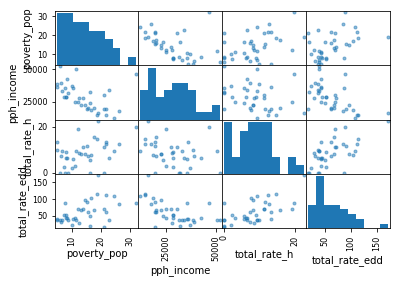

In [79]:
# Plot the scatter matrix for all data
fig = pd.scatter_matrix(df)

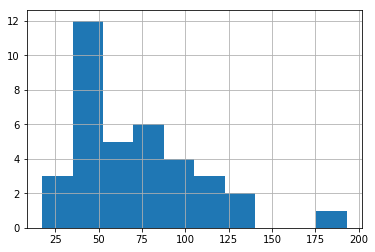

In [96]:
# Plot histogram for hospitalized and discharged patients as one
df['total_rate_h'].add(df['total_rate_edd']).hist()

f1 = plt.gcf

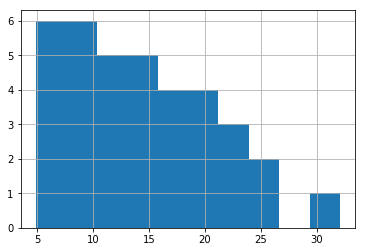

In [97]:
# Plot histogram for poverty
df['poverty_pop'].hist()

f2 = plt.gcf

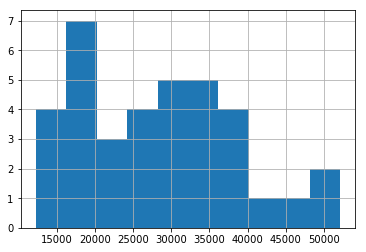

In [98]:
# Plot histogram for person per household income
df['pph_income'].hist()

f3 = plt.gcf

## Part 3: Exploring The Data


In [99]:
# Check how many areas have a median below the poverty income level ($24,600)
n_poverty = len(df[df['pph_income'] <= 24600]['pph_income'])

# Ratio of areas with median income below poverty income level
n_poverty/len(df['pph_income'])

0.3888888888888889

In [95]:
# Determine the area with the lowest and highest income
max_i = df['pph_income'].idxmax
min_i = df['pph_income'].idxmin

# print out the information of these areas
print('Area With Greatest Income: ' + str(df.loc[max_i, 'geography']) + '\nPerson Per Household Income: ' + \
      str(df.loc[max_i, 'pph_income']) + '\nFlu Hospitalization Rate: ' + str(df.loc[max_i, 'total_rate_h']) + \
      '\nFlu Discharge Rate: ' + str(df.loc[max_i, 'total_rate_edd']))

print('\nArea With Lowest Income: ' + str(df.loc[min_i, 'geography']) + '\nPerson Per Household Income: ' + \
      str(df.loc[min_i, 'pph_income']) + '\nFlu Hospitalization Rate: ' + str(df.loc[min_i, 'total_rate_h']) + \
      '\nFlu Discharge Rate: ' + str(df.loc[min_i, 'total_rate_edd']))

Area With Greatest Income: Coronado
Person Per Household Income: 52151.0
Flu Hospitalization Rate: 0.0
Flu Discharge Rate: 38.46987107

Area With Lowest Income: National City
Person Per Household Income: 12209.0
Flu Hospitalization Rate: 9.3896874575
Flu Discharge Rate: 108.819230885


## Part 4: Data Analysis


## Part 5: Discussion & Conclusions

In [ ]:
# You will need the following functions for the last section of the assignment
#  You should not import any other functions
import scipy.stats as stats
from scipy.stats import normaltest
from sklearn.cluster import KMeans
from scipy.cluster.vq import whiten
from sklearn.decomposition import PCA

### Part 6: Testing Distributions


### Part 7: Clustering

### Part 8: Dimensionality Reduction
